In [1]:
import unicodedata
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
import codecs
from sklearn import metrics
import pandas as pd
import numpy as np
import wordcloud

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import ipywidgets as widgets
from IPython import display

#Ignore Future Warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
dataset = pd.read_csv("../input/summarization-final-project/data/dataset/dataset.csv")
dataset

,CATEGORY,CONTENT,SUMMARY
0,business,The Federal Reserve approved Ally Financial In...,The Federal Reserve approved Ally Financial In...
1,business,— Major shareholders of Duke Energy Corp. have...,— Major shareholders of Duke Energy Corp. have...
2,business,Photos taken earlier this month show that Nort...,Photos taken earlier this month show that Nort...
3,business,Thanks to dogged reporting by the Associated P...,Thanks to dogged reporting by the Associated P...
4,business,The energy giant says it is committed to clean...,The energy giant says it is committed to clean...
...,...,...,...
36886,technology,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\nPlease make sure your br...
36887,technology,Google Inc (NASDAQ:GOOGL) GOOGL +1.12% (NASDAQ...,Google Inc (NASDAQ:GOOGL) GOOGL +1.12% (NASDAQ...
36888,technology,Google has purchased New Mexico-based unmanned...,Google has purchased New Mexico-based unmanned...
36889,technology,hidden\n\nLooks like Facebook's plans to get I...,Google has beaten the world's largest social n...


In [3]:
dataset['category_id'] = dataset['CATEGORY'].factorize()[0]
dataset

,CATEGORY,CONTENT,SUMMARY,category_id
0,business,The Federal Reserve approved Ally Financial In...,The Federal Reserve approved Ally Financial In...,0
1,business,— Major shareholders of Duke Energy Corp. have...,— Major shareholders of Duke Energy Corp. have...,0
2,business,Photos taken earlier this month show that Nort...,Photos taken earlier this month show that Nort...,0
3,business,Thanks to dogged reporting by the Associated P...,Thanks to dogged reporting by the Associated P...,0
4,business,The energy giant says it is committed to clean...,The energy giant says it is committed to clean...,0
...,...,...,...,...
36886,technology,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\nPlease make sure your br...,3
36887,technology,Google Inc (NASDAQ:GOOGL) GOOGL +1.12% (NASDAQ...,Google Inc (NASDAQ:GOOGL) GOOGL +1.12% (NASDAQ...,3
36888,technology,Google has purchased New Mexico-based unmanned...,Google has purchased New Mexico-based unmanned...,3
36889,technology,hidden\n\nLooks like Facebook's plans to get I...,Google has beaten the world's largest social n...,3


health           10505
technology       10246
entertainment     8582
business          7558
Name: CATEGORY, dtype: int64


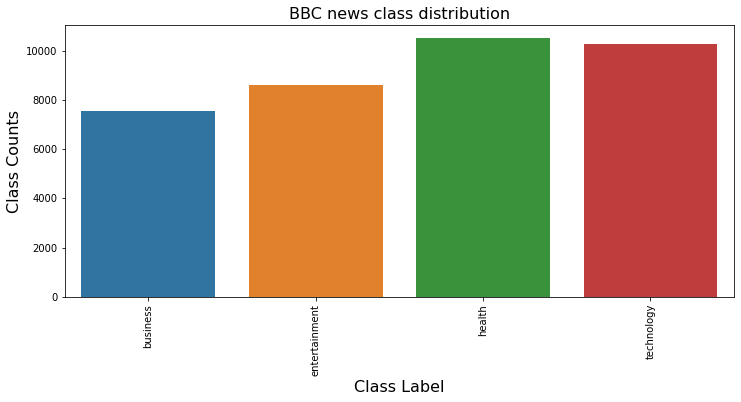

In [4]:

print(dataset['CATEGORY'].value_counts())

plt.figure(figsize=(12,5))
sns.countplot(x=dataset['CATEGORY'])
plt.title('BBC news class distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='vertical');

In [5]:
# Converting the catergory labels into numeric values using Encoder
labelEncoder = preprocessing.LabelEncoder()
dataset['category_id'] = labelEncoder.fit_transform(dataset['CATEGORY'])
print(dataset['category_id'].value_counts())

2    10505
3    10246
1     8582
0     7558
Name: category_id, dtype: int64


# Data Cleaning

In [6]:
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True,printt = False):#, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', ' ', str(text).lower().strip())
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text)
    text = re.sub("\d+", " ", text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    if printt:
        print(f'number of words before removing stop words = {len(lst_text)}')
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if printt:   
        print(f'number of words after removing stop words = {len(lst_text)}')
    
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:

dataset["clean_text"] = dataset["CONTENT"].apply(lambda txt: utils_preprocess_text(txt,flg_stemm=False, flg_lemm=True))
dataset['tokenized'] = dataset['clean_text'].apply(lambda x: nltk.tokenize.word_tokenize(x))
dataset

,CATEGORY,CONTENT,SUMMARY,category_id,clean_text,tokenized
0,business,The Federal Reserve approved Ally Financial In...,The Federal Reserve approved Ally Financial In...,0,federal reserve approved ally financial inc ca...,"[federal, reserve, approved, ally, financial, ..."
1,business,— Major shareholders of Duke Energy Corp. have...,— Major shareholders of Duke Energy Corp. have...,0,major shareholder duke energy corp called comp...,"[major, shareholder, duke, energy, corp, calle..."
2,business,Photos taken earlier this month show that Nort...,Photos taken earlier this month show that Nort...,0,photo taken earlier month show north carolina ...,"[photo, taken, earlier, month, show, north, ca..."
3,business,Thanks to dogged reporting by the Associated P...,Thanks to dogged reporting by the Associated P...,0,thanks dogged reporting associated press know ...,"[thanks, dogged, reporting, associated, press,..."
4,business,The energy giant says it is committed to clean...,The energy giant says it is committed to clean...,0,energy giant say committed cleaning dan river ...,"[energy, giant, say, committed, cleaning, dan,..."
...,...,...,...,...,...,...
36886,technology,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\nPlease make sure your br...,3,happen please make sure browser support javasc...,"[happen, please, make, sure, browser, support,..."
36887,technology,Google Inc (NASDAQ:GOOGL) GOOGL +1.12% (NASDAQ...,Google Inc (NASDAQ:GOOGL) GOOGL +1.12% (NASDAQ...,3,google inc nasdaq googl googl nasdaq goog goog...,"[google, inc, nasdaq, googl, googl, nasdaq, go..."
36888,technology,Google has purchased New Mexico-based unmanned...,Google has purchased New Mexico-based unmanned...,3,google purchased new mexico based unmanned aer...,"[google, purchased, new, mexico, based, unmann..."
36889,technology,hidden\n\nLooks like Facebook's plans to get I...,Google has beaten the world's largest social n...,3,hidden look like facebook plan get internet de...,"[hidden, look, like, facebook, plan, get, inte..."


In [8]:
for in_cluster_id in [0,1,2,3]:
    print(f'===================Collocataion of Category {in_cluster_id}:======================================')
    corpus = dataset[dataset["category_id"]== in_cluster_id]["clean_text"]
    tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    bigrams = nltk.collocations.BigramAssocMeasures()
    trigrams = nltk.collocations.TrigramAssocMeasures()
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
    trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
    bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
    trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

    # create output widgets
    widget1 = widgets.Output()
    widget2 = widgets.Output()

    # render in output widgets
    with widget1:
        display.display(bigramPMITable)
    with widget2:
        display.display(trigramPMITable)

    # create HBox
    hbox = widgets.HBox([widget1, widget2])

    # render hbox
    display.display(hbox)

===================Collocataion of Category 0:======================================


===================Collocataion of Category 1:======================================


===================Collocataion of Category 2:======================================


===================Collocataion of Category 3:======================================


===================Collocataion of Category 0:======================================


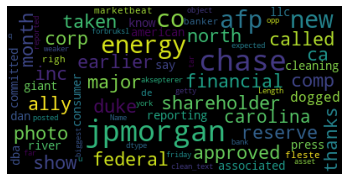

===================Collocataion of Category 1:======================================


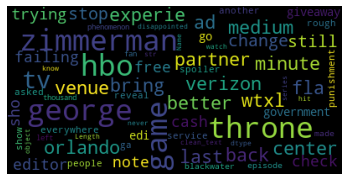

===================Collocataion of Category 2:======================================


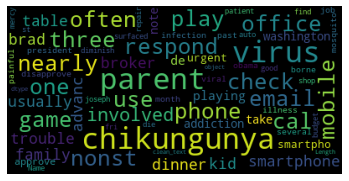

===================Collocataion of Category 3:======================================


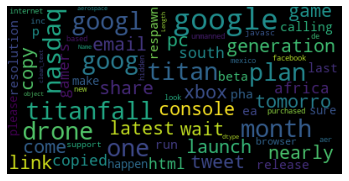

In [9]:
for in_cluster_id in [0,1,2,3]:
    print(f'===================Collocataion of Category {in_cluster_id}:======================================')
    corpus = dataset[dataset["category_id"]== in_cluster_id]["clean_text"]
    wc = wordcloud.WordCloud(background_color='black', max_words=100, max_font_size=35)
    wc = wc.generate(str(corpus))
    fig = plt.figure(num=1)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show()

In [10]:
# Splitting the dataset into Training and Testing Data
train_text, test_text, train_labels, test_labels = train_test_split(dataset["CONTENT"], dataset["category_id"], train_size=0.7, random_state=0)

print("Train x size :", train_text.shape)
print("Train y size :", train_labels.shape)
print("Test x size :", test_text.shape)
print("Test y size :", test_labels.shape)

Train x size : (25823,)
Train y size : (25823,)
Test x size : (11068,)
Test y size : (11068,)


# Feature Engineering

> BOW

In [11]:
# Extracting features by counting word counts (BOW)
#Bag of words
vectorizer = CountVectorizer(min_df=2)
bow_train_features = vectorizer.fit_transform(train_text)
bow_test_features = vectorizer.transform(test_text)

> TFIDF

In [12]:

# Extracting Features with TdIdf
tfIdVector = TfidfVectorizer(min_df=6,norm='l2',smooth_idf=True,use_idf=True)

#Extracting train and test features
tfidTrainFeatures = tfIdVector.fit_transform(train_text)
tfidTestFeatures = tfIdVector.transform(test_text)

# LR Classifier

> BOW

In [13]:

#Logistic Regression Model for training Data using s
logRegModel = LogisticRegression(solver = 'liblinear')
logRegModel.fit(bow_train_features,train_labels)

LogisticRegression(solver='liblinear')

In [14]:
# Finding the predictions of text dataset
predLogReg1 = logRegModel.predict(bow_test_features)
score1 = logRegModel.score(bow_test_features,test_labels)
print("Approximate Accuracy with BOW of LR: ", score1*100)

Approximate Accuracy with BOW of LR:  93.30502349114565


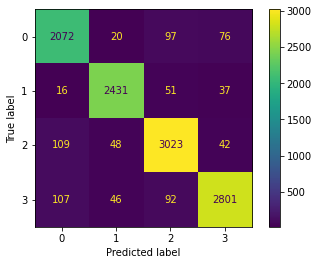

In [15]:
metrics.plot_confusion_matrix(logRegModel ,bow_test_features , test_labels)

> TFIDF

In [16]:
#Logistic Regression Model for training Data with tfid features
logRegModel2 = LogisticRegression(solver = 'liblinear')
logRegModel2.fit(tfidTrainFeatures,train_labels)

LogisticRegression(solver='liblinear')

In [17]:
# Finding the predictions of text dataset
predLogReg2 = logRegModel2.predict(tfidTestFeatures)
score2 = logRegModel2.score(tfidTestFeatures,test_labels)
print("Approximate Accuracy with TfIdf of LR: ", score2*100)

Approximate Accuracy with TfIdf of LR:  93.07914709071197


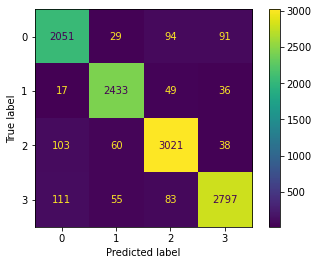

In [18]:
metrics.plot_confusion_matrix(logRegModel2 ,tfidTestFeatures , test_labels)

# Error Analysis: LR Classifier

In [19]:
print(predLogReg1)
(test_labels)

[3 1 3 ... 0 3 2]


33579    3
12361    1
30654    3
23593    2
3316     0
        ..
24752    2
19654    2
3196     0
36359    3
35600    3
Name: category_id, Length: 11068, dtype: int64

In [20]:
dataset['category_id'][35600]

3

In [21]:
dataset['clean_text'][35600]

'dr steven horng boston beth israel deaconess medical center technology thank saving recent patient life came accessing patient file bulky paper match agility google glass horng reliance glass helped quickly find medication patient allergic part larger pilot program instituted hospital morning emergency department staff arrives put futuristic eyewear like would scrub overall goal acclimate hospital employee experience interacting technology medical personnel quick adopt data keeping capability horng also hold degree computer science biomedical informatics basically use information along technology best way possible told boston globe glass enabled better bedside physician well rather excuse said mean quickly access information without interrupt patient lose eye contact even leave room glass also used take picture record instructional video send file wearer staff conduct test patient ass health current version stock however run android based platform designed company called wearable inte

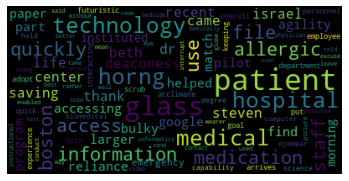

In [22]:

wc = wordcloud.WordCloud(background_color='black', max_words=100, max_font_size=35)
wc = wc.generate(str(dataset['clean_text'][35600]))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [23]:

tokens = dataset['tokenized'][35600]
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(bigramPMITable)
with widget2:
    display.display(trigramPMITable)

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
display.display(hbox)

# Naive Bayes Classifier

> BOW

In [24]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(bow_train_features,train_labels)

predictions = mnb.predict(bow_test_features)

score3 = mnb.score(bow_test_features, test_labels)
print("Naive baysian Bag of words accuracy",score3*100,'%')

Naive baysian Bag of words accuracy 90.08854354897 %


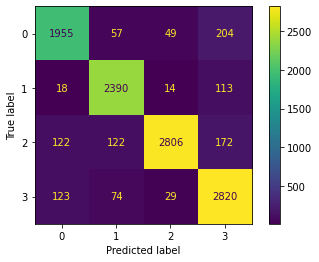

In [25]:
metrics.plot_confusion_matrix(mnb ,bow_test_features , test_labels)

> TFIDF

In [26]:
mnb = MultinomialNB()

mnb.fit(tfidTrainFeatures,train_labels)

pred = mnb.predict(tfidTestFeatures)

score4 = mnb.score(tfidTestFeatures, test_labels)
print("Naive baysian Tfidf accuracy",score4*100,'%')

Naive baysian Tfidf accuracy 90.74810263823636 %


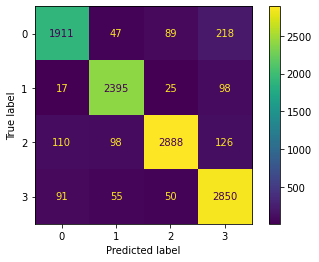

In [27]:
metrics.plot_confusion_matrix(mnb ,tfidTestFeatures , test_labels)

# Error Analysis: NB Classifier

In [28]:
# print(list(pred))
# print(test_labels)

In [29]:

tokens = dataset['tokenized'][36359]
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(bigramPMITable)
with widget2:
    display.display(trigramPMITable)

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
display.display(hbox)

# Random Forest Classifier

> BOW

In [30]:
clf = RandomForestClassifier(n_estimators=20, n_jobs=1)

In [31]:
clf.fit(bow_train_features,train_labels)
pred = clf.predict(bow_test_features)
score5 = accuracy_score(pred, test_labels)
print("Accuracy using Random Forest BoW: {}".format(accuracy_score(pred, test_labels)*100))

Accuracy using Random Forest BoW: 89.10372244307915


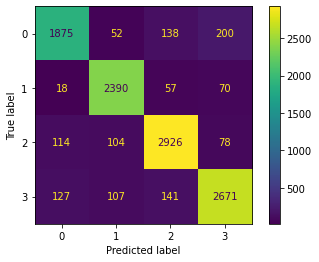

In [32]:
metrics.plot_confusion_matrix(clf ,bow_test_features , test_labels)

> TFIDF

In [33]:
clf = RandomForestClassifier(n_estimators=20, n_jobs=1)
clf.fit(tfidTrainFeatures,train_labels )

pred = clf.predict(tfidTestFeatures)
score6 = accuracy_score(pred, test_labels)
print("Accuracy using Random Forest Tfidf: {}".format(accuracy_score(pred, test_labels)*100))

Accuracy using Random Forest Tfidf: 88.97723165883629


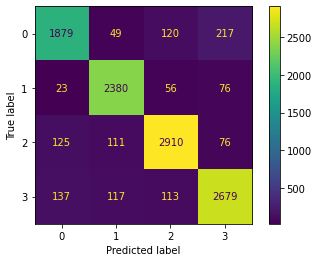

In [34]:
metrics.plot_confusion_matrix(clf ,tfidTestFeatures , test_labels)

# Clustering

> Reassigning labels

In [35]:
# https://docs.neurodata.io/notebooks/pedigo/graspologic/clustering/2020/10/12/remapping-labels.html
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
def remap_labels(y_true, y_pred, return_map=False):
    """
    Remaps a categorical labeling (such as one predicted by a clustering algorithm) to
    match the labels used by another similar labeling.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth labels, or, labels to map to.
    y_pred : array-like of shape (n_samples,)
        Labels to remap to match the categorical labeling of `y_true`.

    Returns
    -------
    remapped_y_pred : np.ndarray of shape (n_samples,)
        Same categorical labeling as that of `y_pred`, but with the category labels
        permuted to best match those of `y_true`.
    label_map : dict
        Mapping from the original labels of `y_pred` to the new labels which best
        resemble those of `y_true`.

    Examples
    --------
    >>> y_true = np.array([0,0,1,1,2,2])
    >>> y_pred = np.array([2,2,1,1,0,0])
    >>> remap_labels(y_true, y_pred)
    array([0, 0, 1, 1, 2, 2])

    """
    confusion_mat = confusion_matrix(y_true, y_pred)
    row_inds, col_inds = linear_sum_assignment(confusion_mat, maximize=True)
    label_map = dict(zip(col_inds, row_inds))
    remapped_y_pred = np.vectorize(label_map.get)(y_pred)
    if return_map:
        return remapped_y_pred, label_map
    else:
        return remapped_y_pred

> BOW

In [36]:
from sklearn.cluster import KMeans
kms = KMeans(n_clusters=4, init='k-means++', max_iter=300,n_init = 1,random_state=42,verbose=0)
kms.fit(bow_train_features)
print('Cohen kappa of BOW clustering before remaping labels',metrics.cohen_kappa_score(train_labels, kms.labels_))
print('silhoutte score of BOW clustering = ',metrics.silhouette_score(bow_train_features, kms.labels_))
relabels = remap_labels(train_labels , kms.labels_)
print('Cohen kappa of BOW clustering after remaping labels',metrics.cohen_kappa_score(train_labels, relabels))
score7 = accuracy_score(relabels, train_labels)
print(f'Accuracy of clustering labels: {score7*100}%')

Cohen kappa of BOW clustering before remaping labels 0.03501655037942142
silhoutte score of BOW clustering =  0.0914915950769373
Cohen kappa of BOW clustering after remaping labels 0.07519409872347749
Accuracy of clustering labels: 31.293807845718934%


> TFIDF

In [37]:
kms = KMeans(n_clusters=4, init='k-means++', max_iter=300,n_init = 1,random_state=42,verbose=0)
kms.fit(tfidTrainFeatures)
print('Cohen kappa of TFIDF clustering before remaping labels',metrics.cohen_kappa_score(train_labels, kms.labels_))
print('silhoutte score of TFIDF clustering = ',metrics.silhouette_score(tfidTrainFeatures, kms.labels_))
relabels = remap_labels(train_labels , kms.labels_)
print('Cohen kappa of TFIDF clustering after remaping labels',metrics.cohen_kappa_score(train_labels, relabels))
score8 = accuracy_score(relabels, train_labels)
print(f'Accuracy of clustering labels: {score8*100}%')

Cohen kappa of TFIDF clustering before remaping labels -0.0666374888308836
silhoutte score of TFIDF clustering =  0.009422738349267334
Cohen kappa of TFIDF clustering after remaping labels 0.3927563231804636
Accuracy of clustering labels: 55.11753088332107%


# Performance Visualizations

In [38]:
accuracy_list = [score1 , score2, score3, score4, score5, score6, score7, score8]
accuracy_labels= ['BOW_LR', 'TFIDF_LR', 'BOW_NB', 'TFIDF_NB', 'BOW_RF', 'TFIDF_RF', 'BOW_KMANS', 'TFIDF_KMEANS']

In [39]:
results = pd.DataFrame([accuracy_labels ,accuracy_list ])
results

,0,1,2,3,4,5,6,7
0,BOW_LR,TFIDF_LR,BOW_NB,TFIDF_NB,BOW_RF,TFIDF_RF,BOW_KMANS,TFIDF_KMEANS
1,0.93305,0.930791,0.900885,0.907481,0.891037,0.889772,0.312938,0.551175


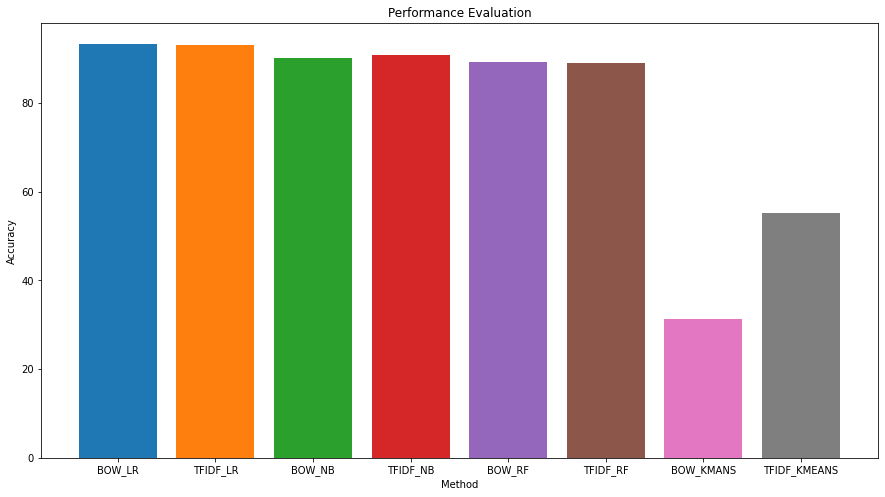

In [40]:
# algorithm comparison
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
for i in range(len(accuracy_list)):
    plt.bar(accuracy_labels[i] ,accuracy_list[i]*100)
# plt.legend()
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Performance Evaluation')
plt.show()

# Error Analysis

In [41]:
print(relabels)
print(train_labels)

[1 3 3 ... 3 2 1]
9030     1
35793    3
27173    3
14662    1
36481    3
        ..
20757    2
32103    3
30403    3
21243    2
2732     0
Name: category_id, Length: 25823, dtype: int64


In [42]:

tokens = dataset['tokenized'][9030]
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(bigramPMITable)
with widget2:
    display.display(trigramPMITable)

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
display.display(hbox)

# Summarization

# Estractive Summarization: LSA

In [43]:
!pip install sumy
# Installing sumy library for implementing the LSA model.
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

     |████████████████████████████████| 83 kB 1.2 MB/s 
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21680 sha256=f4a8ef19baea61a427b6ea2213ee509d78d69460e15f554afa3e0af89c5b8f3b
  Stored in directory: /root/.cache/pip/wheels/d4/bf/51/81d27ad638e1a6dca4f362ecc33d1e2c764b8ea7ec751b8fc1
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=1ac1d50d7c1764b747546bb4b9ca6c0c0379c61928684f5eb183ced58d0735a0
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built breadability docopt


In [44]:
pd.options.mode.chained_assignment = None
dataset["LSA_Summary"] = ""
for i,j in dataset.iterrows():
    parser = PlaintextParser.from_string(j.CONTENT,Tokenizer("english"))
    summarizer_lsa = LsaSummarizer()
    summary2 = summarizer_lsa(parser.document,5)
    for sentence in summary2:
        dataset.LSA_Summary[i] = sentence
dataset

/opt/conda/lib/python3.7/site-packages/sumy/summarizers/lsa.py:76: UserWarning: Number of words (116) is lower than number of sentences (134). LSA algorithm may not work properly.
  warn(message % (words_count, sentences_count))


,CATEGORY,CONTENT,SUMMARY,category_id,clean_text,tokenized,LSA_Summary
0,business,The Federal Reserve approved Ally Financial In...,The Federal Reserve approved Ally Financial In...,0,federal reserve approved ally financial inc ca...,"[federal, reserve, approved, ally, financial, ...",Ally’s plan was approved after the Federal Res...
1,business,— Major shareholders of Duke Energy Corp. have...,— Major shareholders of Duke Energy Corp. have...,0,major shareholder duke energy corp called comp...,"[major, shareholder, duke, energy, corp, calle...",A federal grand jury also is investigating any...
2,business,Photos taken earlier this month show that Nort...,Photos taken earlier this month show that Nort...,0,photo taken earlier month show north carolina ...,"[photo, taken, earlier, month, show, north, ca...",Once again Duke failed to notify the agency of...
3,business,Thanks to dogged reporting by the Associated P...,Thanks to dogged reporting by the Associated P...,0,thanks dogged reporting associated press know ...,"[thanks, dogged, reporting, associated, press,...",A federal investigation is underway regarding ...
4,business,The energy giant says it is committed to clean...,The energy giant says it is committed to clean...,0,energy giant say committed cleaning dan river ...,"[energy, giant, say, committed, cleaning, dan,...",Scanzoni says it will be several years before ...
...,...,...,...,...,...,...,...
36886,technology,Why did this happen?\n\nPlease make sure your ...,Why did this happen?\nPlease make sure your br...,3,happen please make sure browser support javasc...,"[happen, please, make, sure, browser, support,...",For more information you can review our Terms ...
36887,technology,Google Inc (NASDAQ:GOOGL) GOOGL +1.12% (NASDAQ...,Google Inc (NASDAQ:GOOGL) GOOGL +1.12% (NASDAQ...,3,google inc nasdaq googl googl nasdaq goog goog...,"[google, inc, nasdaq, googl, googl, nasdaq, go...",Titan Aerospace claims that its drones can pro...
36888,technology,Google has purchased New Mexico-based unmanned...,Google has purchased New Mexico-based unmanned...,3,google purchased new mexico based unmanned aer...,"[google, purchased, new, mexico, based, unmann...",Titan is working to develop two UAVs that rese...
36889,technology,hidden\n\nLooks like Facebook's plans to get I...,Google has beaten the world's largest social n...,3,hidden look like facebook plan get internet de...,"[hidden, look, like, facebook, plan, get, inte...",Titan is developing a variety of solar-powered...


# Evaluation

In [45]:
dataset['SUMMARY'][0]

'The Federal Reserve approved Ally Financial Inc.’s capital plan in the bank regulator’s annual review of the industry’s financial health, clearing another potential hurdle to the auto lender’s plans to exit government ownership.\nAlly’s plan was approved after the Federal Reserve found that the bank could keep lending in a severe economic downturn, according to a report Wednesday.'

In [46]:
dataset['LSA_Summary'][0]

<Sentence: Ally’s plan was approved after the Federal Reserve found that the bank could keep lending in a severe economic downturn, according to a report Wednesday.>

In [47]:
dataset['CATEGORY'][0]

'business'

In [48]:
import spacy

nlp = spacy.load("en_core_web_lg")
doc1 = nlp("dataset['SUMMARY'][0]")
doc2 = nlp("dataset['LSA_Summary'][0]")

print('The similarity between two articles is = ',doc1.similarity(doc2))

The similarity between two articles is =  0.9999999648775513


# Bert summarizer

In [49]:
!pip install bert-extractive-summarizer
from summarizer import Summarizer,TransformerSummarizer
bert_model = Summarizer()
bert_summary = ''.join(bert_model(dataset['CONTENT'][0], min_length=60))

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [50]:
bert_summary

'The Federal Reserve approved Ally Financial Inc.’s capital plan in the bank regulator’s annual review of the industry’s financial health, clearing another potential hurdle to the auto lender’s plans to exit government ownership. Ally’s plan was approved after the Federal Reserve found that the bank could keep lending in a severe economic downturn, according to a report Wednesday.'

In [51]:
import spacy

nlp = spacy.load("en_core_web_lg")
doc1 = nlp("dataset['SUMMARY'][0]")
doc2 = nlp(bert_summary)

print('The similarity between two articles is = ',doc1.similarity(doc2))

The similarity between two articles is =  0.17754551291345758
